In [4]:
import os
import json
import torch
import pickle
import json
import bertviz
import uuid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import MultipleLocator
from collections import Counter
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from IPython.core.display import display, HTML, Javascript
from bertviz.util import format_special_chars, format_attention, num_layers, num_heads
LAYER_NUM = 36
HEAD_NUM = 20
HEAD_DIM = 64
HIDDEN_DIM = HEAD_NUM * HEAD_DIM
torch.set_default_device("cuda")

/tmp/ipykernel_594332/1236972398.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [5]:
def transfer_output(model_output):
    all_pos_layer_input = []
    all_pos_attn_output = []
    all_pos_residual_output = []
    all_pos_ffn_output = []
    all_pos_layer_output = []
    all_last_attn_subvalues = []
    all_pos_coefficient_scores = []
    all_attn_scores = []
    for layer_i in range(LAYER_NUM):
        cur_layer_input = model_output[layer_i][0]
        cur_attn_output = model_output[layer_i][1]
        cur_residual_output = model_output[layer_i][2]
        cur_ffn_output = model_output[layer_i][3]
        cur_layer_output = model_output[layer_i][4]
        cur_last_attn_subvalues = model_output[layer_i][5]
        cur_coefficient_scores = model_output[layer_i][6]
        cur_attn_weights = model_output[layer_i][7]
        all_pos_layer_input.append(cur_layer_input[0].tolist())
        all_pos_attn_output.append(cur_attn_output[0].tolist())
        all_pos_residual_output.append(cur_residual_output[0].tolist())
        all_pos_ffn_output.append(cur_ffn_output[0].tolist())
        all_pos_layer_output.append(cur_layer_output[0].tolist())
        all_last_attn_subvalues.append(cur_last_attn_subvalues[0].tolist())
        all_pos_coefficient_scores.append(cur_coefficient_scores[0].tolist())
        all_attn_scores.append(cur_attn_weights)
    return all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, \
           all_pos_layer_output, all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores
def get_bsvalues(vector, model, final_var):
    E = torch.mean(vector, -1)
    vector_ln = (vector-E.unsqueeze(-1))/final_var * model.transformer.ln_f.weight.data
    vector_bsvalues = model.lm_head(vector_ln).data
    return vector_bsvalues
def get_prob(vector):
    prob = torch.nn.Softmax(-1)(vector)
    return prob
def get_fc2_params(model, layer_num):
    return model.transformer.h[layer_num].mlp.c_proj.weight.data.T
def transfer_l(l):
    new_x, new_y = [], []
    for x in l:
        new_x.append(x[0])
        new_y.append(x[1])
    return new_x, new_y
def plt_bar(x, y, yname="log increase"):
    x_major_locator=MultipleLocator(1)
    plt.figure(figsize=(8, 3))
    ax=plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    plt_x = [a/2 for a in x]
    plt.xlim(-0.5, plt_x[-1]+0.49)
    x_attn, y_attn, x_ffn, y_ffn = [], [], [], []
    for i in range(len(x)):
        if i%2 == 0:
            x_attn.append(x[i]/2)
            y_attn.append(y[i])
        else:
            x_ffn.append(x[i]/2)
            y_ffn.append(y[i])
    plt.bar(x_attn, y_attn, color="darksalmon", label="attention layers")
    plt.bar(x_ffn, y_ffn, color="lightseagreen", label="FFN layers")
    plt.xlabel("layer")
    plt.ylabel(yname)
    plt.legend()
    plt.show()
def plt_heatmap(data):
    xLabel = range(len(data[0]))
    yLabel = range(len(data))
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    im = ax.imshow(data, cmap=plt.cm.hot_r)
    #plt.colorbar(im)
    plt.title("attn head log increase heatmap")
    plt.show()

In [6]:
import torch

print(torch.version.cuda)  # Which CUDA version PyTorch expects
print(torch.cuda.is_available())
print(torch.cuda.device_count())


12.1
True
2


In [7]:
modelname = "../../scratch/save_models/gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
model = GPT2LMHeadModel.from_pretrained("gpt2-large")
model.eval()
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [9]:
test_sentence = "Tim Duncan plays the sport of"
indexed_tokens = tokenizer.encode(test_sentence)
tokens = [tokenizer.decode(x) for x in indexed_tokens]
tokens_tensor = torch.tensor([indexed_tokens])
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]
predicted_top10 = torch.argsort(predictions[0][-1], descending=True)[:10]
predicted_text = [tokenizer.decode(x) for x in predicted_top10]
print(test_sentence, "=>", predicted_text)
print(len(outputs))
# length of the key value pairs of 36 (layer_num)
print(len(outputs[1]))

layer_num = 0
print(len(outputs[1][layer_num]))
all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, all_pos_layer_output, \
all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores = transfer_output(outputs[1])
final_var = ((torch.var(torch.tensor(all_pos_layer_output[-1][-1]), -1, unbiased=False)+1e-5)**0.5).item()
pos_len = len(tokens)
print(tokens)

Tim Duncan plays the sport of => [' basketball', ' golf', ' tennis', ' football', ' soccer', ' hockey', ' professional', ' ultimate', ' Ultimate', ' boxing']
2
36
8
['Tim', ' Duncan', ' plays', ' the', ' sport', ' of']


In [10]:
predict_index = predicted_top10[0].item()
print(predict_index, tokenizer.decode(predict_index))

9669  basketball


attn sum:  5.5859999999999985 ffn sum:  4.406000000000001
attn:  [('21', 0.698), ('19', 0.471), ('28', 0.443), ('23', 0.4), ('30', 0.4), ('25', 0.343), ('26', 0.32), ('17', 0.292), ('32', 0.211), ('22', 0.194), ('18', 0.192), ('35', 0.138), ('4', 0.127), ('15', 0.124), ('8', 0.117), ('7', 0.116), ('13', 0.114), ('24', 0.113), ('0', 0.109), ('12', 0.093), ('5', 0.092), ('6', 0.086), ('16', 0.077), ('3', 0.072), ('1', 0.065), ('14', 0.064), ('2', 0.062), ('27', 0.059), ('34', 0.053), ('20', 0.044), ('11', 0.036), ('9', 0.035), ('31', 0.018), ('33', 0.008), ('10', -0.006), ('29', -0.194)]
ffn:  [('27', 0.706), ('28', 0.603), ('22', 0.566), ('25', 0.458), ('18', 0.389), ('26', 0.387), ('21', 0.364), ('29', 0.324), ('24', 0.312), ('23', 0.238), ('30', 0.226), ('13', 0.175), ('17', 0.17), ('20', 0.165), ('12', 0.135), ('14', 0.095), ('0', 0.049), ('11', 0.042), ('31', 0.039), ('2', 0.022), ('1', 0.021), ('10', 0.008), ('15', -0.004), ('3', -0.01), ('16', -0.017), ('5', -0.031), ('19', -0.034

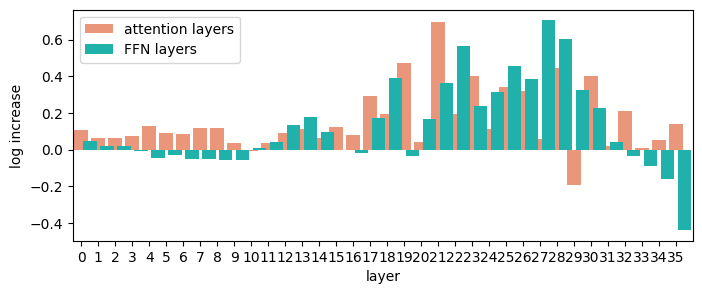

In [11]:
#layer-level increase
all_attn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_attn_vector = torch.tensor(all_pos_attn_output[layer_i][-1])
    cur_layer_input = torch.tensor(all_pos_layer_input[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_layer_input, model, final_var))[predict_index])
    cur_attn_vector_plus = cur_attn_vector + cur_layer_input
    cur_attn_vector_bsvalues = get_bsvalues(cur_attn_vector_plus, model, final_var)
    cur_attn_vector_probs = get_prob(cur_attn_vector_bsvalues)
    cur_attn_vector_probs = cur_attn_vector_probs[predict_index]
    cur_attn_vector_probs_log = torch.log(cur_attn_vector_probs)
    cur_attn_vector_probs_log_increase = cur_attn_vector_probs_log - origin_prob_log
    all_attn_log_increase.append(cur_attn_vector_probs_log_increase.item())
all_ffn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_ffn_vector = torch.tensor(all_pos_ffn_output[layer_i][-1])
    cur_residual = torch.tensor(all_pos_residual_output[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_residual, model, final_var))[predict_index])
    cur_ffn_vector_plus = cur_ffn_vector + cur_residual
    cur_ffn_vector_bsvalues = get_bsvalues(cur_ffn_vector_plus, model, final_var)
    cur_ffn_vector_probs = get_prob(cur_ffn_vector_bsvalues)
    cur_ffn_vector_probs = cur_ffn_vector_probs[predict_index]
    cur_ffn_vector_probs_log = torch.log(cur_ffn_vector_probs)
    cur_ffn_vector_probs_log_increase = cur_ffn_vector_probs_log - origin_prob_log
    all_ffn_log_increase.append(cur_ffn_vector_probs_log_increase.tolist())
attn_list, ffn_list = [], []
for layer_i in range(LAYER_NUM):
    attn_list.append([str(layer_i), all_attn_log_increase[layer_i]])
    ffn_list.append([str(layer_i), all_ffn_log_increase[layer_i]])
attn_list_sort = sorted(attn_list, key=lambda x: x[-1])[::-1]#[:10]
ffn_list_sort = sorted(ffn_list, key=lambda x: x[-1])[::-1]#[:10]
attn_increase_compute, ffn_increase_compute = [], []
for indx, increase in attn_list_sort:
    attn_increase_compute.append((indx, round(increase, 3)))
for indx, increase in ffn_list_sort:
    ffn_increase_compute.append((indx, round(increase, 3)))
print("attn sum: ", sum([x[1] for x in attn_increase_compute]), 
      "ffn sum: ", sum([x[1] for x in ffn_increase_compute]))
print("attn: ", attn_increase_compute)
print("ffn: ", ffn_increase_compute)
all_increases_draw = []
for i in range(len(attn_list)):
    all_increases_draw.append(attn_list[i][1])
    all_increases_draw.append(ffn_list[i][1])    
plt_bar(range(len(all_increases_draw)), all_increases_draw)

[['21_19', 0.6981], ['28_18', 0.4259], ['23_13', 0.3098], ['27_15', 0.2711], ['19_0', 0.2553], ['26_7', 0.2506], ['30_1', 0.2473], ['32_19', 0.2105], ['19_10', 0.1891], ['24_2', 0.1857], ['25_12', 0.1812], ['30_5', 0.1664], ['17_3', 0.1613], ['22_8', 0.159], ['23_18', 0.1237], ['25_13', 0.1156], ['12_2', 0.1148], ['19_5', 0.1035], ['22_17', 0.0999], ['24_19', 0.0956]]


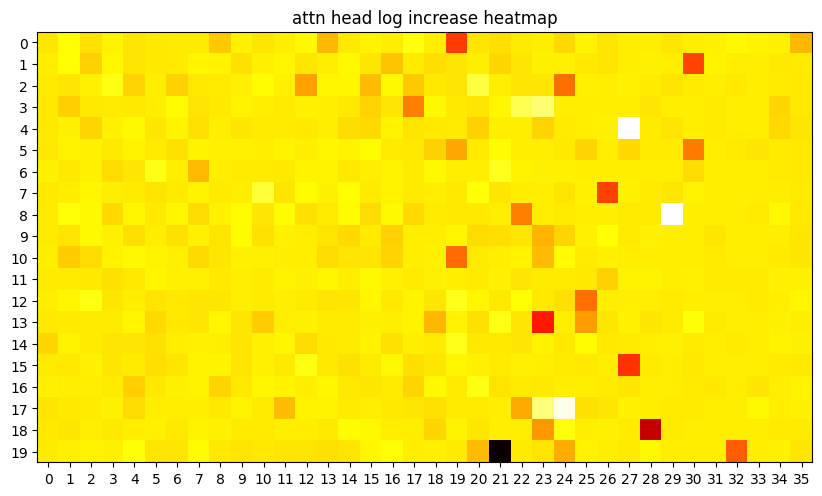

In [12]:
#head-level increase
all_head_increase = []
for test_layer in range(LAYER_NUM):
    cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
    cur_v_heads = torch.tensor(all_last_attn_subvalues[test_layer])
    cur_attn_o_split = model.transformer.h[test_layer].attn.c_proj.weight.data.view(HEAD_NUM, HEAD_DIM, -1)
    cur_attn_subvalues_headrecompute = torch.bmm(cur_v_heads, cur_attn_o_split).permute(1, 0, 2)
    cur_attn_subvalues_head_sum = torch.sum(cur_attn_subvalues_headrecompute, 0)
    cur_layer_input_last = cur_layer_input[-1]
    origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
    cur_attn_subvalues_head_plus = cur_attn_subvalues_head_sum + cur_layer_input_last
    cur_attn_plus_probs = torch.log(get_prob(get_bsvalues(
            cur_attn_subvalues_head_plus, model, final_var))[:, predict_index])
    cur_attn_plus_probs_increase = cur_attn_plus_probs - origin_prob
    for i in range(len(cur_attn_plus_probs_increase)):
        all_head_increase.append([str(test_layer)+"_"+str(i), round(cur_attn_plus_probs_increase[i].item(), 4)])

all_head_increase_sort = sorted(all_head_increase, key=lambda x:x[-1])[::-1]
print(all_head_increase_sort[:20])
all_head_increase_list = [x[1] for x in all_head_increase]
all_head_increase_list_split = torch.tensor(all_head_increase_list).view((LAYER_NUM, HEAD_NUM)).permute((1,0)).tolist()
plt_heatmap(all_head_increase_list_split)

In [13]:
test_layer, test_head = 21, 19
cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
cur_v_heads = torch.tensor(all_last_attn_subvalues[test_layer])
cur_attn_o_split = model.transformer.h[test_layer].attn.c_proj.weight.data.view(HEAD_NUM, HEAD_DIM, -1)
cur_attn_subvalues_headrecompute = torch.bmm(cur_v_heads, cur_attn_o_split).permute(1, 0, 2)
cur_attn_subvalues_headrecompute_curhead = cur_attn_subvalues_headrecompute[:, test_head, :]
cur_layer_input_last = cur_layer_input[-1]
origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
cur_attn_subvalues_headrecompute_curhead_plus = cur_attn_subvalues_headrecompute_curhead + cur_layer_input_last
cur_attn_subvalues_headrecompute_curhead_plus_probs = torch.log(get_prob(get_bsvalues(
    cur_attn_subvalues_headrecompute_curhead_plus, model, final_var))[:, predict_index])
cur_attn_subvalues_headrecompute_increase = cur_attn_subvalues_headrecompute_curhead_plus_probs - origin_prob
cur_attn_subvalues_headrecompute_increase_zip = list(zip(range(len(cur_attn_subvalues_headrecompute_increase)), 
    tokens, cur_attn_subvalues_headrecompute_increase.tolist()))
cur_attn_subvalues_headrecompute_increase_zip_sort = sorted(cur_attn_subvalues_headrecompute_increase_zip,
    key=lambda x:x[-1])[::-1]
cur_layer_input_bsvalues = get_bsvalues(cur_layer_input, model, final_var)
cur_layer_input_bsvalues_sort = torch.argsort(cur_layer_input_bsvalues, descending=True)
cur_attn_subvalues_headrecompute_curhead_bsvalues = get_bsvalues(
    cur_attn_subvalues_headrecompute_curhead, model, final_var)
cur_attn_subvalues_headrecompute_curhead_bsvalues_sort = torch.argsort(
    cur_attn_subvalues_headrecompute_curhead_bsvalues, descending=True)
key_input = cur_layer_input.clone()
key_input -= torch.tensor(all_pos_layer_input[0])
for layer_i in range(test_layer):
    key_input -= torch.tensor(all_pos_ffn_output[layer_i])
key_input_bsvalues = get_bsvalues(key_input, model, final_var)
key_input_bsvalues_sort = torch.argsort(key_input_bsvalues, descending=True)
print(list(zip(range(len(tokens)), tokens)))
for pos, word, increase in cur_attn_subvalues_headrecompute_increase_zip_sort:
    print("\n", pos, word, "increase: ", round(increase, 4), "attn: ", round(
        all_attn_scores[test_layer][0][test_head][-1][pos].item(), 4))
    print("layer input: ", [tokenizer.decode(x) for x in cur_layer_input_bsvalues_sort[pos][:20]])
    print("key: ", [tokenizer.decode(x) for x in key_input_bsvalues_sort[pos][:20]])
    print("value: ", [tokenizer.decode(x) for x in cur_attn_subvalues_headrecompute_curhead_bsvalues_sort[pos][:10]])

[(0, 'Tim'), (1, ' Duncan'), (2, ' plays'), (3, ' the'), (4, ' sport'), (5, ' of')]

 1  Duncan increase:  0.5208 attn:  0.5343
layer input:  ["'s", ' Jr', ' injury', ',', ' Sr', ' Smith', ' and', ' (', ' Johnson', ' Returns', ' host', ')', ' Scott', 'son', ' retirement', ' Xavier', ' MP', ' Mc', ' Hit', ' Quint']
key:  [' retire', ' Duncan', ' retirement', ' injuries', ' veteran', ' Bryant', ' teams', '":{"', ' retired', ' aging', ' Ray', ' players', ' team', 'Coach', ' plays', ' played', ' Game', ' MVP', ' teammate', ' career']
value:  ['basketball', ' basketball', ' Basketball', 'NBA', ' Wizards', ' NBA', ' Athlet', 'asketball', ' athletic', ' Kobe']

 4  sport increase:  0.1021 attn:  0.1839
layer input:  ['iest', 'sw', ' club', 'scar', ' side', 'est', 'ive', 'atorium', ' of', ' recre', ' clubs', ' leagues', ' Club', ' playing', ' world', ' sports', ' alongside', ' competitive', ' game', 'y']
key:  [' role', ' anthem', ' Reggie', ' basketball', ' sports', ' mascot', ' game', ' hims

In [14]:
n_heads = num_heads(all_attn_scores)
attn_data = []
include_layers = list(range(num_layers(all_attn_scores)))
include_heads = list(range(n_heads))
attention1 = format_attention(all_attn_scores, None)
attn_data.append({'name': None, 'attn': attention1.tolist(), 'left_text': tokens, 'right_text': tokens})
vis_id = 'bertviz-%s'%(uuid.uuid4().hex)
select_html = ""
vis_html = f"""      
        <div id="{vis_id}" style="font-family:'Helvetica Neue', Helvetica, Arial, sans-serif;">
            <span style="user-select:none">
                Layer: <select id="layer"></select>
                {select_html}
            </span>
            <div id='vis'></div>
        </div>
    """
if True:
    for d in attn_data:
        attn_seq_len_left = len(d['attn'][0][0]) #16
        attn_seq_len_right = len(d['attn'][0][0][0]) #16
        d['left_text'] = format_special_chars(d['left_text'])
        d['right_text'] = format_special_chars(d['right_text'])
params = {
        'attention': attn_data,
        'default_filter': "0",
        'root_div_id': vis_id,
        'layer': None,
        'heads': None,
        'include_layers': include_layers
        }
display(HTML('<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>'))
display(HTML(vis_html))
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(bertviz.__file__)))
vis_js = open(os.path.join(__location__, 'head_view.js')).read().replace("PYTHON_PARAMS", json.dumps(params))
display(Javascript(vis_js))

<IPython.core.display.Javascript object>

In [15]:
#FFN neuron
all_ffn_subvalues = []
for layer_i in range(LAYER_NUM):
    coefficient_scores = torch.tensor(all_pos_coefficient_scores[layer_i][-1])
    fc2_vectors = get_fc2_params(model, layer_i)
    ffn_subvalues = (coefficient_scores * fc2_vectors).T
    all_ffn_subvalues.append(ffn_subvalues)
ffn_subvalue_list = []
for layer_i in range(LAYER_NUM):
    cur_ffn_subvalues = all_ffn_subvalues[layer_i]
    cur_residual = torch.tensor(all_pos_residual_output[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_residual, model, final_var))[predict_index])
    cur_ffn_subvalues_plus = cur_ffn_subvalues + cur_residual
    cur_ffn_subvalues_bsvalues = get_bsvalues(cur_ffn_subvalues_plus, model, final_var)
    cur_ffn_subvalues_probs = get_prob(cur_ffn_subvalues_bsvalues)
    cur_ffn_subvalues_probs = cur_ffn_subvalues_probs[:, predict_index]
    cur_ffn_subvalues_probs_log = torch.log(cur_ffn_subvalues_probs)
    cur_ffn_subvalues_probs_log_increase = cur_ffn_subvalues_probs_log - origin_prob_log
    for index, ffn_increase in enumerate(cur_ffn_subvalues_probs_log_increase):
        ffn_subvalue_list.append([str(layer_i)+"_"+str(index), ffn_increase.item()])
ffn_subvalue_list_sort = sorted(ffn_subvalue_list, key=lambda x: x[-1])[::-1]
for x in ffn_subvalue_list_sort[:10]:
    print(x[0], round(x[1], 4))
    layer = int(x[0].split("_")[0])
    neuron = int(x[0].split("_")[1])
    cur_vector = get_fc2_params(model, layer).T[neuron]
    cur_vector_bsvalue = get_bsvalues(cur_vector, model, final_var)
    cur_vector_bsvalue_sort = torch.argsort(cur_vector_bsvalue, descending=True)
    print("top10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[:10]])
    print("last10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[-10:]])

28_29 0.4481
top10:  [' soccer', ' football', ' Soccer', ' basketball', 'Players', ' Basketball', ' players', ' Football', ' rugby', ' athletes']
last10:  [' centr', ' Hive', 'ornings', 'asio', ' Dialogue', ' Dahl', 'Tesla', 'Compan', 'luster', 'hedon']
21_983 0.2473
top10:  [' football', ' Football', 'Football', ' NFL', ' Steelers', ' Blazers', ' Oilers', ' Rangers', ' Panthers', ' baseball']
last10:  ['natureconservancy', 'rup', ' Juno', ' Esther', 'Anne', 'cn', 'GES', ' Osc', ' Cindy', ' bis']
24_4743 0.2323
top10:  [' coaches', ' jerseys', ' coaching', 'Players', 'Coach', ' coach', ' league', 'Football', 'ESPN', ' teammates']
last10:  [' declass', ' Burr', ' SX', ' chained', 'SPONSORED', 'otom', ' Piper', ' lithium', ' Cheong', ' Turing']
27_1254 0.1643
top10:  [' Pacers', ' Knicks', ' Basketball', ' NBA', 'NBA', ' Cavs', ' rim', ' Curry', ' dun', ' Pistons']
last10:  [' Oy', ' rugby', ' Labrador', ' Stadium', ' cricket', ' CONC', ' CFL', ' NASL', ' Rugby', ' Gork']
27_3482 0.1453


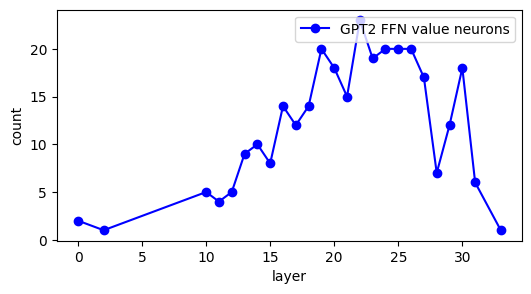

In [16]:
FFN_value_neurons = [x[0] for x in ffn_subvalue_list_sort[:300]]
FFN_layer_count_value = [int(x.split("_")[0]) for x in list(FFN_value_neurons)]
FFN_layer_count_value = Counter(FFN_layer_count_value)
FFN_layer_count_value = sorted(zip(FFN_layer_count_value.keys(), FFN_layer_count_value.values()))
gpt_FFN_value_x, gpt_FFN_value_y = transfer_l(FFN_layer_count_value)

plt.figure(figsize=(6,3))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(gpt_FFN_value_x, gpt_FFN_value_y, "bo-", label="GPT2 FFN value neurons")
plt.xlabel("layer", fontsize=10)
plt.ylabel("count", fontsize=10)
plt.legend(fontsize=10, loc="upper right")
plt.show()

In [17]:
#attn neuron (pos)
cur_file_attn_neuron_list = []
for test_layer in range(LAYER_NUM):
    cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
    cur_v_heads_recompute = torch.tensor(all_last_attn_subvalues[test_layer]).permute(1, 0, 2)
    cur_attn_o_split = model.transformer.h[test_layer].attn.c_proj.weight.data.view(HEAD_NUM, HEAD_DIM, -1)
    cur_attn_o_recompute = cur_attn_o_split * cur_v_heads_recompute.unsqueeze(-1)
    cur_layer_input_last = cur_layer_input[-1]
    origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
    cur_attn_o_head_plus = cur_attn_o_recompute + cur_layer_input_last
    cur_attn_plus_probs = torch.log(get_prob(get_bsvalues(
        cur_attn_o_head_plus, model, final_var))[:, :, :, predict_index])
    cur_attn_plus_probs_increase = cur_attn_plus_probs - origin_prob
    for pos_index in range(cur_attn_plus_probs_increase.size(0)):
        for head_index in range(cur_attn_plus_probs_increase.size(1)):
            for attn_neuron_index in range(cur_attn_plus_probs_increase.size(2)):
                cur_file_attn_neuron_list.append((str(test_layer)+"_"+str(head_index)+"_"+str(
                    attn_neuron_index)+"_"+str(pos_index), 
                    cur_attn_plus_probs_increase[pos_index][head_index][attn_neuron_index].item()))
cur_file_attn_neuron_list_sort = sorted(cur_file_attn_neuron_list, key=lambda x: x[-1])[::-1]
print(list(zip(range(len(tokens)), tokens)))
for x in cur_file_attn_neuron_list_sort[:10]:
    layer_i, head_i, neuron_i, _ = x[0].split("_")
    layer_i, head_i, neuron_i = int(layer_i), int(head_i), int(neuron_i)
    cur_neuron = model.transformer.h[layer_i].attn.c_proj.weight.data.view(HEAD_NUM, HEAD_DIM, -1)[head_i][neuron_i]
    cur_neuron_bsvalue = get_bsvalues(cur_neuron, model, final_var)
    cur_neuron_bsvalue_sort = torch.argsort(cur_neuron_bsvalue, descending=True)
    print(x[0], round(x[1], 4), "top10: ", [tokenizer.decode(a) for a in cur_neuron_bsvalue_sort[:10]])
    print(x[0], round(x[1], 4), "last10: ", [tokenizer.decode(a) for a in cur_neuron_bsvalue_sort[-10:]])

[(0, 'Tim'), (1, ' Duncan'), (2, ' plays'), (3, ' the'), (4, ' sport'), (5, ' of')]
21_19_7_1 0.0712 top10:  ['ryce', ' locker', ' Reggie', ' basketball', 'asketball', 'ernandez', ' Pepsi', ' Roz', ' Bing', ' Basketball']
21_19_7_1 0.0712 last10:  [' orc', ' Minotaur', ' Forsaken', ' Mith', ' Dwar', ' Shaman', 'olkien', ' orcs', ' Orc', ' Tolkien']
21_19_5_1 0.0559 top10:  ['UFC', ' Mayhem', ' MMA', ' Mutant', 'fighter', ' fighters', ' Cyborg', ' superheroes', ' Romero', 'fighters']
21_19_5_1 0.0559 last10:  [' pear', ' whis', 'buff', ' Tillerson', ' Swift', 'jong', ' Roose', ' Carbuncle', 'anship', ' keynote']
23_13_36_1 0.0452 top10:  [' ROCK', ' Ronnie', ' Singer', ' Yon', 'Rock', ' Xie', ' Rock', ' Mick', ' rock', 'ogie']
23_13_36_1 0.0452 last10:  [' Leh', 'Bra', ' Hamm', ' Kah', 'Rachel', 'Hamilton', 'Sah', ' Hilbert', 'Fra', ' Kau']
28_18_10_1 0.0386 top10:  [' Frozen', ' Hull', ' Highlander', ' Bronze', ' Finn', ' Corsair', ' Spoiler', ' Cornwall', ' Rune', ' Alpine']
28_18_10_

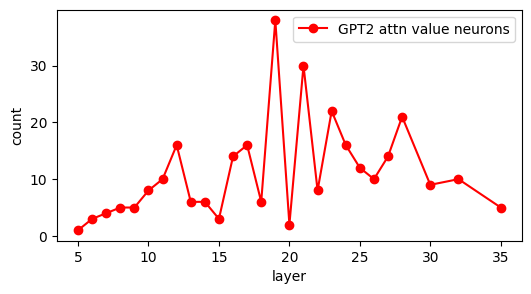

In [18]:
attn_value_neurons = [x[0] for x in cur_file_attn_neuron_list_sort[:300]]
attn_layer_count_value = [int(x.split("_")[0]) for x in list(attn_value_neurons)]
attn_layer_count_value = Counter(attn_layer_count_value)
attn_layer_count_value = sorted(zip(attn_layer_count_value.keys(), attn_layer_count_value.values()))
gpt_attn_value_x, gpt_attn_value_y = transfer_l(attn_layer_count_value)

plt.figure(figsize=(6,3))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(gpt_attn_value_x, gpt_attn_value_y, "ro-", label="GPT2 attn value neurons")
plt.xlabel("layer", fontsize=10)
plt.ylabel("count", fontsize=10)
plt.legend(fontsize=10, loc="upper right")
plt.show()

[(19.0, 0.5351), (17.0, 0.4908), (21.0, 0.4661), (22.5, 0.3634), (18.0, 0.2816), (16.0, 0.2608), (13.0, 0.2384), (12.0, 0.2243), (18.5, 0.2087), (10.0, 0.2063), (8.0, 0.1796), (15.0, 0.1749), (6.0, 0.1739), (23.0, 0.16), (7.0, 0.1412), (26.0, 0.1371), (11.0, 0.1313), (16.5, 0.13), (9.0, 0.1246), (5.0, 0.1234), (25.0, 0.1209), (22.0, 0.1182), (28.5, 0.1003), (4.0, 0.0911), (14.0, 0.0889), (10.5, 0.0887), (11.5, 0.0777), (27.5, 0.0747), (13.5, 0.0744), (14.5, 0.0698), (21.5, 0.0649), (20.0, 0.0611), (26.5, 0.0506), (30.0, 0.0438), (29.5, 0.0416), (3.0, 0.0403), (8.5, 0.0399), (24.0, 0.0318), (23.5, 0.0311), (24.5, 0.022), (12.5, 0.0163), (28.0, 0.0159), (0.0, 0.0158), (30.5, 0.0119), (25.5, 0.0111), (4.5, 0.0081), (19.5, 0.0018), (31.0, 0.0012), (32.0, 0.0008), (33.0, 0.0007), (35.5, 0.0), (35.0, 0.0), (34.5, 0.0), (34.0, 0.0), (33.5, 0.0), (32.5, -0.0005), (31.5, -0.0008), (1.0, -0.0028), (2.0, -0.008), (17.5, -0.0283), (-0.5, -0.0322), (7.5, -0.0324), (0.5, -0.0376), (29.0, -0.0385), (

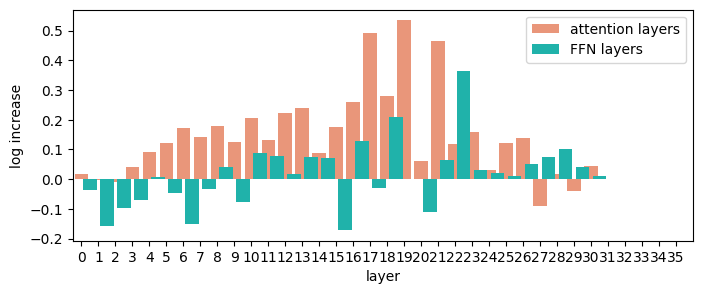

In [19]:
#find query layers activating FFN neurons
all_residual_scores = [0.0]*(1+2*LAYER_NUM)
for l_n, increase_score in ffn_subvalue_list_sort[:100]:
    ffn_layer, ffn_neuron = l_n.split("_")
    ffn_layer, ffn_neuron = int(ffn_layer), int(ffn_neuron)
    ffn_neuron_key = model.transformer.h[ffn_layer].mlp.c_fc.weight.data[:, ffn_neuron]
    ffn_neuron_key_new = ffn_neuron_key * model.transformer.h[ffn_layer].ln_2.weight.data
    last_layer_residualstream = [torch.tensor(all_pos_layer_input[0][-1]).unsqueeze(0)]
    for layer_i in range(ffn_layer):
        last_layer_residualstream.append(torch.tensor(all_pos_attn_output[layer_i][-1]).unsqueeze(0))
        last_layer_residualstream.append(torch.tensor(all_pos_ffn_output[layer_i][-1]).unsqueeze(0))
    last_layer_residualstream.append(torch.tensor(all_pos_attn_output[ffn_layer][-1]).unsqueeze(0))
    last_layer_residualstream_cat = torch.cat(last_layer_residualstream, 0)
    last_layer_residualstream_innerproduct = torch.sum(last_layer_residualstream_cat*ffn_neuron_key_new, -1)
    last_layer_residualstream_innerproduct_zip = list(zip(range(len(last_layer_residualstream_innerproduct)), last_layer_residualstream_innerproduct.tolist()))
    sum_inner_product = sum([x[1] for x in last_layer_residualstream_innerproduct_zip])
    for l, inner in last_layer_residualstream_innerproduct_zip:
        all_residual_scores[l] += inner/sum_inner_product * increase_score
all_residual_scores_zip = list(zip(range(len(all_residual_scores)), all_residual_scores))
all_residual_scores_zip_sort = sorted(all_residual_scores_zip, key=lambda x: x[-1])[::-1]
print([(a[0]/2-0.5, round(a[1],4)) for a in all_residual_scores_zip_sort])
plt_bar(range(len(all_residual_scores[1:])), all_residual_scores[1:])

avg_attn:  21.74
[(0.5, 0.2297258402173744), (27.5, 0.14565653607314047), (2.5, 0.13629015771699943), (1.5, 0.12135871175889072), (19.0, 0.10023940472362357), (9.5, 0.09156385292274445), (11.5, 0.08734011367132874), (0.0, 0.08041231364321184), (7.5, 0.07709461191748845), (4.5, 0.06787902522270209)]


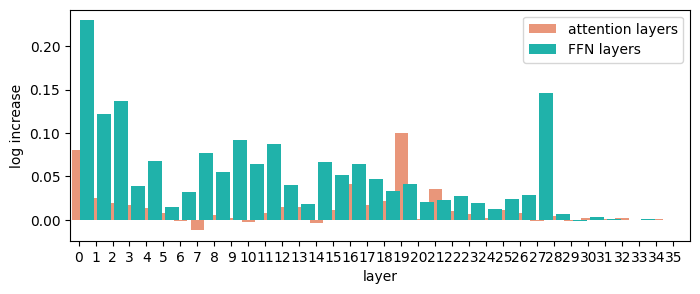

In [20]:
#find query layers activating attn neurons
all_residual_scores = [0.0]*(1+2*LAYER_NUM)
avg_attn_layer_curdir = []
for l_h_n_p, increase_score in cur_file_attn_neuron_list_sort[:100]:
    attn_layer, attn_head, attn_neuron, attn_pos = l_h_n_p.split("_")
    attn_layer, attn_head, attn_neuron, attn_pos = int(attn_layer), int(attn_head), int(attn_neuron), int(attn_pos)
    avg_attn_layer_curdir.append(attn_layer)
    cur_attn_neuron = attn_head*HEAD_DIM+attn_neuron
    attn_neuron_key = model.transformer.h[attn_layer].attn.c_attn.weight.data[:, 2560:][:, cur_attn_neuron]
    attn_neuron_key_new = attn_neuron_key * model.transformer.h[attn_layer].ln_1.weight.data
    pos_layer_residualstream = [torch.tensor(all_pos_layer_input[0][attn_pos]).unsqueeze(0)]
    for layer_i in range(attn_layer):
        pos_layer_residualstream.append(torch.tensor(all_pos_attn_output[layer_i][attn_pos]).unsqueeze(0))
        pos_layer_residualstream.append(torch.tensor(all_pos_ffn_output[layer_i][attn_pos]).unsqueeze(0))
    pos_layer_residualstream_cat = torch.cat(pos_layer_residualstream, 0)
    pos_layer_residualstream_innerproduct = torch.sum(pos_layer_residualstream_cat*attn_neuron_key_new, -1)
    pos_layer_residualstream_innerproduct_zip = list(zip(range(len(pos_layer_residualstream_innerproduct)), pos_layer_residualstream_innerproduct.tolist()))
    sum_inner_product = sum([x[1] for x in pos_layer_residualstream_innerproduct_zip])
    for l, inner in pos_layer_residualstream_innerproduct_zip:
        all_residual_scores[l] += inner/sum_inner_product * increase_score
all_residual_scores_zip = list(zip(range(len(all_residual_scores)), all_residual_scores))
all_residual_scores_zip_sort = sorted(all_residual_scores_zip, key=lambda x: x[-1])[::-1]
print("avg_attn: ", sum(avg_attn_layer_curdir)/len(avg_attn_layer_curdir))
print([(a[0]/2-0.5, a[1]) for a in all_residual_scores_zip_sort[:10]])
plt_bar(range(len(all_residual_scores[1:])), all_residual_scores[1:])

In [21]:
#find query FFN neurons activating attn neurons
curfile_ffn_score_dict = {}
for l_h_n_p, increase_score in cur_file_attn_neuron_list_sort[:30]:
    attn_layer, attn_head, attn_neuron, attn_pos = l_h_n_p.split("_")
    attn_layer, attn_head, attn_neuron, attn_pos = int(attn_layer), int(attn_head), int(attn_neuron), int(attn_pos)
    cur_attn_neuron = attn_head*HEAD_DIM+attn_neuron
    attn_neuron_key = model.transformer.h[attn_layer].attn.c_attn.weight.data[:, 2560:][:, cur_attn_neuron]
    attn_neuron_key_new = attn_neuron_key * model.transformer.h[attn_layer].ln_1.weight.data
    cur_inner_all = torch.sum(torch.tensor(all_pos_layer_input[attn_layer][attn_pos])*attn_neuron_key_new, -1)
    for layer_i in range(attn_layer):
        cur_layer_neurons = (torch.tensor(all_pos_coefficient_scores[layer_i][attn_pos])*get_fc2_params(model, layer_i)).T
        cur_layer_neurons_innerproduct = torch.sum(cur_layer_neurons * attn_neuron_key_new, -1)/cur_inner_all
        for neuron_i in range(len(cur_layer_neurons_innerproduct)):
            if str(layer_i)+"_"+str(neuron_i) not in curfile_ffn_score_dict:
                curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] = 0.0
            curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] += cur_layer_neurons_innerproduct[neuron_i].item() * increase_score

In [22]:
cur_file_neurons_ffn_zip = list(zip(curfile_ffn_score_dict.keys(), curfile_ffn_score_dict.values()))
cur_file_neurons_ffn_zip_sort = sorted(cur_file_neurons_ffn_zip, key=lambda x: x[-1])[::-1]
for x in cur_file_neurons_ffn_zip_sort[:10]:
    print(x[0], round(x[1], 4))
    layer = int(x[0].split("_")[0])
    neuron = int(x[0].split("_")[1])
    cur_vector = get_fc2_params(model, layer).T[neuron]
    cur_vector_bsvalue = get_bsvalues(cur_vector, model, final_var)
    cur_vector_bsvalue_sort = torch.argsort(cur_vector_bsvalue, descending=True)
    print("top10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[:10]])
    print("last10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[-10:]])

27_1254 0.0682
top10:  [' Pacers', ' Knicks', ' Basketball', ' NBA', 'NBA', ' Cavs', ' rim', ' Curry', ' dun', ' Pistons']
last10:  [' Oy', ' rugby', ' Labrador', ' Stadium', ' cricket', ' CONC', ' CFL', ' NASL', ' Rugby', ' Gork']
0_1984 0.0244
top10:  [' Jah', ' Kare', 'jad', ' Ware', ' Towns', ' Nuggets', ' OT', ' Rim', ' Mahmoud', ' Ily']
last10:  ['�', ' tweet', 'gradient', 'gans', 'medium', 'IUM', 'views', 'Ros', ' Kick', ' Juno']
16_505 0.0199
top10:  [' scoring', ' defensive', ' positional', ' backfield', ' combo', ' attacking', ' defender', ' matchup', ' attacker', ' attackers']
last10:  ['rawdownload', 'oreAndOnline', '�', ' externalToEVA', '\x02', ' サーティ', ' dialect', '�', '\x08', 'doms']
4_1707 0.0169
top10:  [' Skydragon', 'osi', 'Stat', ' baskets', 'ogle', ' arithmetic', ' Shooter', 'forts', ' DISTRICT', 'pson']
last10:  [' unfl', ' complimentary', 'iverpool', ' backstage', 'uning', 'uned', ' buds', 'ettel', 'iated', 'iless']
6_2476 0.0159
top10:  [' Pelicans', ' Nets', '

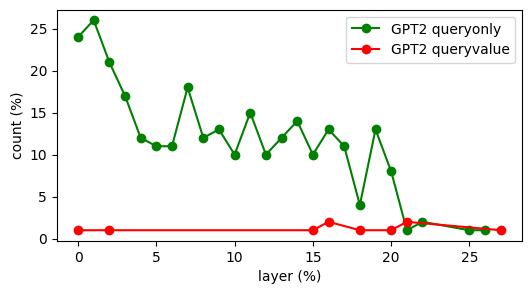

In [23]:
value_neurons = [x[0] for x in ffn_subvalue_list_sort[:300]]
query_neurons = [x[0] for x in cur_file_neurons_ffn_zip_sort[:300]]
queryvalue_neurons = set(value_neurons) & set(query_neurons)
queryonly_neurons = set(query_neurons) - queryvalue_neurons
layer_count_queryonly = [int(x.split("_")[0]) for x in list(queryonly_neurons)]
layer_count_queryonly = Counter(layer_count_queryonly)
layer_count_queryonly = sorted(zip(layer_count_queryonly.keys(), layer_count_queryonly.values()))
gpt_queryonly_x, gpt_queryonly_y = transfer_l(layer_count_queryonly)
layer_count_queryvalue = [int(x.split("_")[0]) for x in list(queryvalue_neurons)]
layer_count_queryvalue = Counter(layer_count_queryvalue)
layer_count_queryvalue = sorted(zip(layer_count_queryvalue.keys(), layer_count_queryvalue.values()))
gpt_queryvalue_x, gpt_queryvalue_y = transfer_l(layer_count_queryvalue)

plt.figure(figsize=(6,3))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(gpt_queryonly_x, gpt_queryonly_y, "go-", label="GPT2 queryonly")
plt.plot(gpt_queryvalue_x, gpt_queryvalue_y, "ro-", label="GPT2 queryvalue")
plt.xlabel("layer (%)", fontsize=10)
plt.ylabel("count (%)", fontsize=10)
plt.legend(fontsize=10, loc="upper right")
plt.show()

In [24]:
curfile_ffn_score_dict = {}
l_h_n_p = "21_19_7_1"
attn_layer, attn_head, attn_neuron, attn_pos = l_h_n_p.split("_")
attn_layer, attn_head, attn_neuron, attn_pos = int(attn_layer), int(attn_head), int(attn_neuron), int(attn_pos)
cur_attn_neuron = attn_head*HEAD_DIM+attn_neuron
attn_neuron_key = model.transformer.h[attn_layer].attn.c_attn.weight.data[:, 2560:][:, cur_attn_neuron]
attn_neuron_key_new = attn_neuron_key * model.transformer.h[attn_layer].ln_1.weight.data
cur_inner_all = torch.sum(torch.tensor(all_pos_layer_input[attn_layer][attn_pos])*attn_neuron_key_new, -1)
for layer_i in range(attn_layer):
    cur_layer_neurons = (torch.tensor(all_pos_coefficient_scores[layer_i][attn_pos])*get_fc2_params(model, layer_i)).T
    cur_layer_neurons_innerproduct = torch.sum(cur_layer_neurons * attn_neuron_key_new, -1)/cur_inner_all
    for neuron_i in range(len(cur_layer_neurons_innerproduct)):
        if str(layer_i)+"_"+str(neuron_i) not in curfile_ffn_score_dict:
            curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] = 0.0
        curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] += cur_layer_neurons_innerproduct[neuron_i].item() * increase_score
cur_file_neurons_ffn_zip = list(zip(curfile_ffn_score_dict.keys(), curfile_ffn_score_dict.values()))
cur_file_neurons_ffn_zip_sort = sorted(cur_file_neurons_ffn_zip, key=lambda x: x[-1])[::-1]
for x in cur_file_neurons_ffn_zip_sort[:10]:
    print(x[0], round(x[1], 4))
    layer = int(x[0].split("_")[0])
    neuron = int(x[0].split("_")[1])
    cur_vector = get_fc2_params(model, layer).T[neuron]
    cur_vector_bsvalue = get_bsvalues(cur_vector, model, final_var)
    cur_vector_bsvalue_sort = torch.argsort(cur_vector_bsvalue, descending=True)
    print("top10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[:10]])
    print("last10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[-10:]])

0_1984 0.0015
top10:  [' Jah', ' Kare', 'jad', ' Ware', ' Towns', ' Nuggets', ' OT', ' Rim', ' Mahmoud', ' Ily']
last10:  ['�', ' tweet', 'gradient', 'gans', 'medium', 'IUM', 'views', 'Ros', ' Kick', ' Juno']
16_4791 0.0015
top10:  [' rapper', ' jog', ' Solitaire', ' gravy', ' laced', ' Lawyers', ' Manny', ' defendant', ' Zimmer', ' teen']
last10:  ['エ', 'poll', 'Poll', 'page', 'letter', '龍�', 'rift', 'thread', 'tp', 'ヘラ']
17_1442 0.0013
top10:  [' preseason', ' Panthers', ' postseason', ' coach', ' rookie', ' defensive', ' Football', ' coaching', ' coaches', ' rosters']
last10:  [' Fet', ' Rite', ' Twain', ' Chains', ' lith', ' Knot', ' Cree', ' pier', ' Cir', ' Coffin']
1_4603 0.0011
top10:  ['onsense', 'opathy', 'onom', 'clerosis', 'cloth', ' pastoral', ' Annotations', ' Alec', ' scrape', 'orter']
last10:  ['emo', ' Deadline', 'ft', 'ITION', 'DEN', 'eger', ' Cond', ' Cup', 'launch', ' Ragnarok']
2_191 0.001
top10:  ['hran', 'resa', ' Tec', 'oslav', 'rament', 'rees', 'nets', 'ierre',

In [25]:
attn_layer, attn_head, attn_neuron, attn_pos = l_h_n_p.split("_")
attn_layer, attn_head, attn_neuron, attn_pos = int(attn_layer), int(attn_head), int(attn_neuron), int(attn_pos)
test_query_neuron = "0_1984"
test_query_layer, test_query_index = test_query_neuron.split("_")
test_query_layer, test_query_index = int(test_query_layer), int(test_query_index)
cur_neuron_vector = get_fc2_params(model, test_query_layer).T[test_query_index]
cur_neuron_vector_ln = model.transformer.h[attn_layer].ln_1(cur_neuron_vector)
cur_neuron_v = model.transformer.h[attn_layer].attn.c_attn(
    cur_neuron_vector_ln)[2560:][attn_head*HEAD_DIM:attn_head*HEAD_DIM+HEAD_DIM]
cur_attn_o_split = model.transformer.h[attn_layer].attn.c_proj.weight.data.view(
    HEAD_NUM, HEAD_DIM, -1)[attn_head]
cur_neuron_vo = torch.sum(cur_neuron_v.unsqueeze(1)*cur_attn_o_split, 0)
cur_neuron_o_bsvalues = get_bsvalues(cur_neuron_vo, model, final_var)
cur_neuron_o_bsvalues_sort = torch.argsort(cur_neuron_o_bsvalues, descending=True)
print("top: ", [tokenizer.decode(x) for x in cur_neuron_o_bsvalues_sort[:10]])
print("last: ", [tokenizer.decode(x) for x in cur_neuron_o_bsvalues_sort[-10:]])

top:  ['basketball', ' Basketball', ' basketball', ' NBA', 'NBA', 'asketball', ' Celtics', ' Lakers', ' Nets', ' Knicks']
last:  [' diesel', ' manif', ' Corsair', ' Juno', ' turb', ' Sov', 'abal', ' Imperial', ' Dresden', ' Faction']
